In [1]:
import numpy as np
from numpy.polynomial import Polynomial

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Callable

In [2]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 123

## Интерполяционный многочлен в форме Ньютона

In [3]:
def calc_divided_diff(nodes: np.ndarray, func_values: np.ndarray) -> np.ndarray:
    '''
    Calculate the divided differences table
    '''
    assert(nodes.size == func_values.size)
    
    n = nodes.size
    coef_table = np.zeros([n, n])
    coef_table[:, 0] = func_values
    
    for j in range(1, n):
        for i in range(j, n):
            coef_table[i, j] = (coef_table[i, j-1] - coef_table[i-1, j-1]) / (nodes[i] - nodes[i-j])
            
    return coef_table


def newton_poly(nodes: np.ndarray, func_values: np.ndarray, nodes_to_calc: np.ndarray):
    '''
    Таблица разделённых разностей, значения интерп. мн-на (ИМ) и 1ой производной ИМ в заданных точках
    '''
    assert(nodes.size == func_values.size)
    
    n = nodes.size
    coef_table = calc_divided_diff(nodes, func_values)
    
    polynom_values = np.full_like(nodes_to_calc, coef_table[0, 0])
    curr_prod = np.ones_like(nodes_to_calc)
    
    for i in range(1, n):
        curr_prod *= (nodes_to_calc - nodes[i-1])
        polynom_values += coef_table[i, i] * curr_prod
        
    poly = coef_table[0, 0] + sum([coef_table[i, i] * Polynomial.fromroots(nodes[:i]) for i in range(1, n)])
    assert(np.linalg.norm(poly(nodes_to_calc) - polynom_values) < 1e-5)
    
    return coef_table, polynom_values, poly.deriv()(nodes_to_calc)

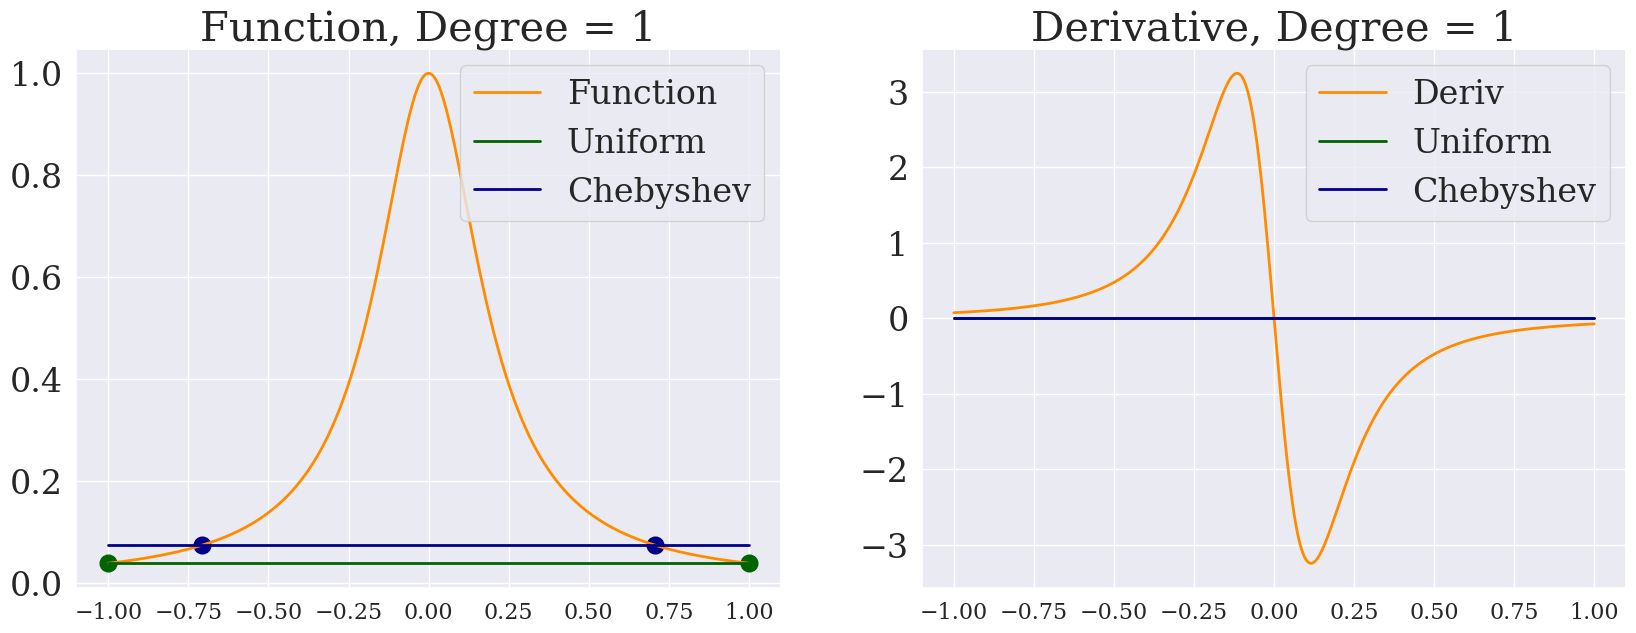

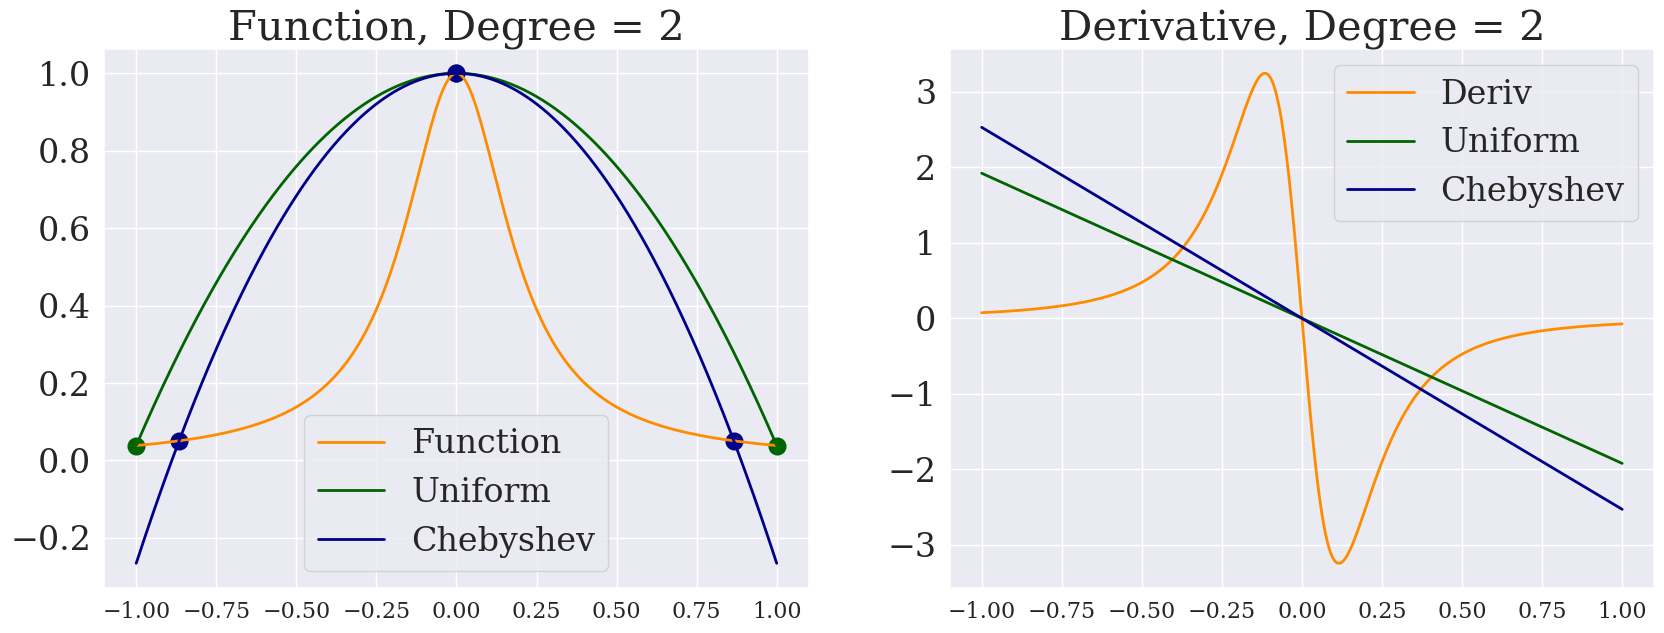

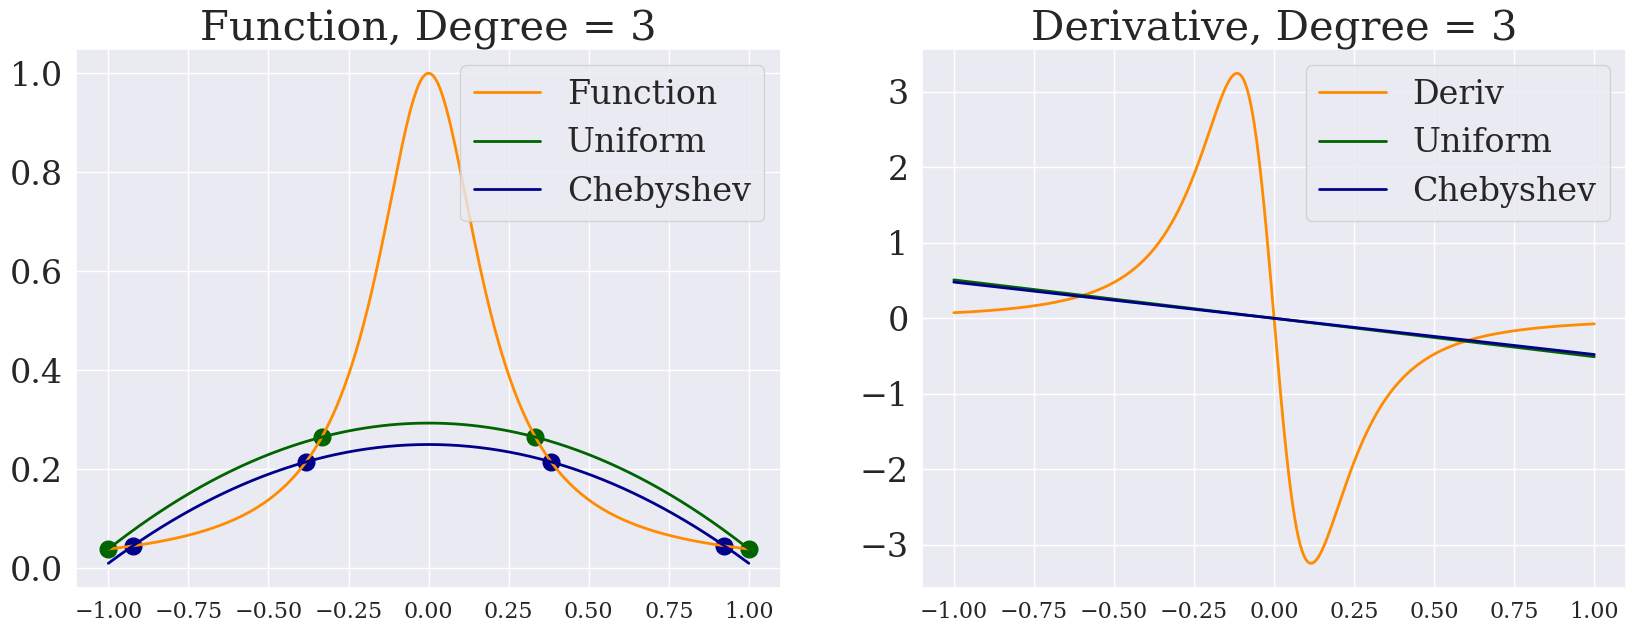

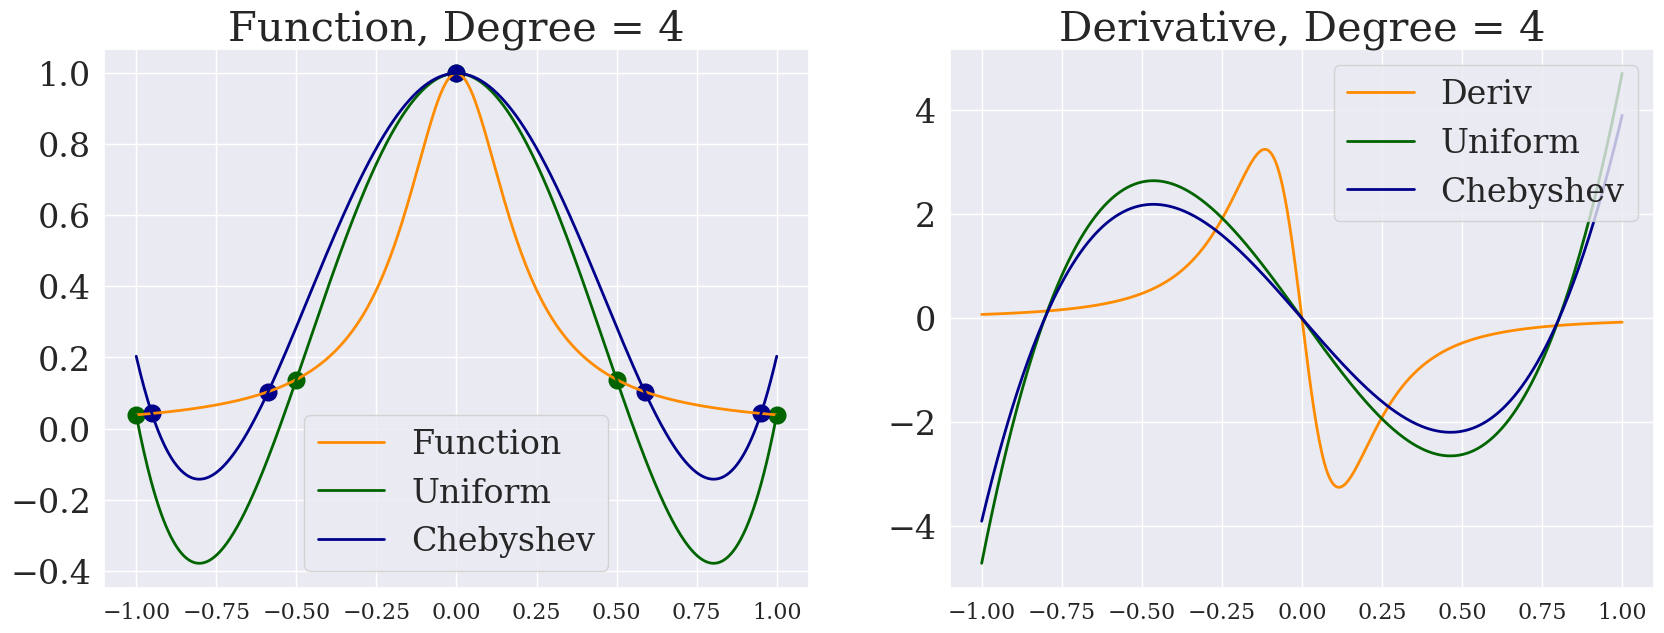

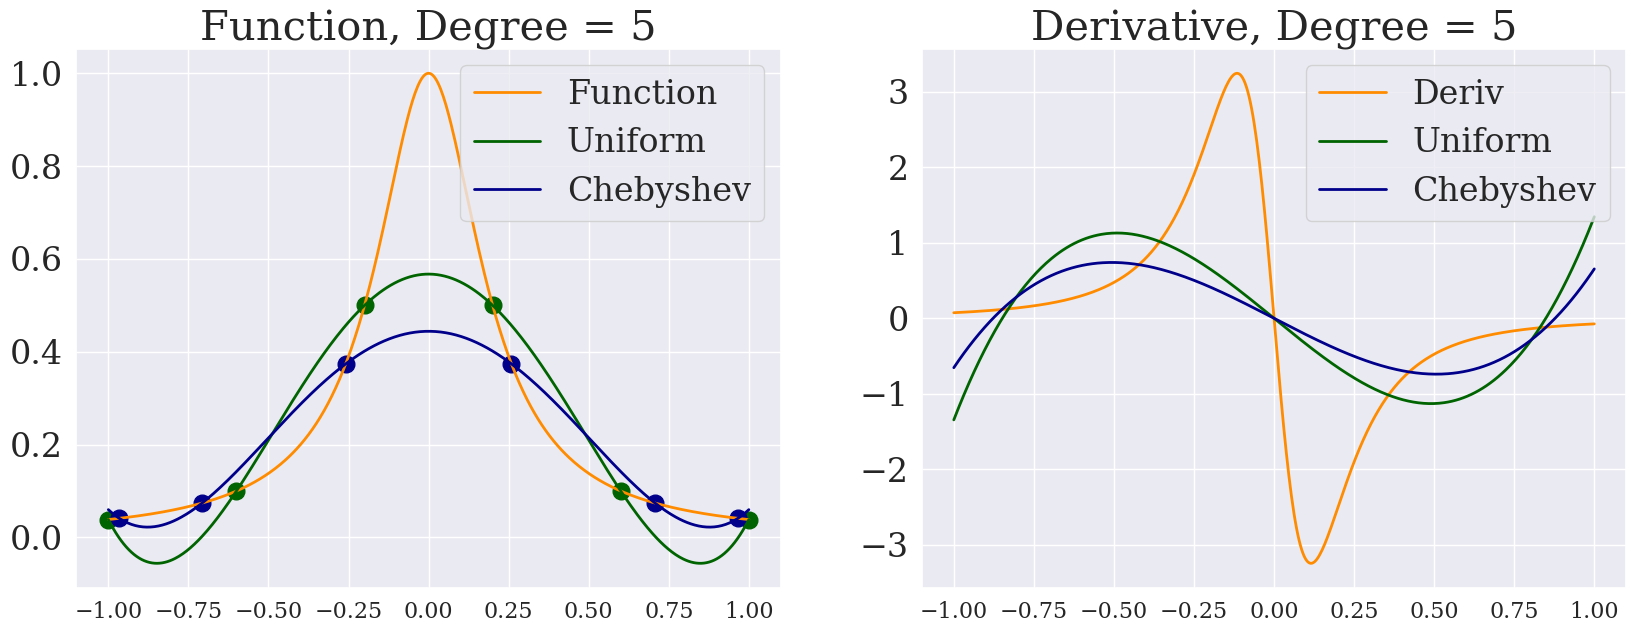

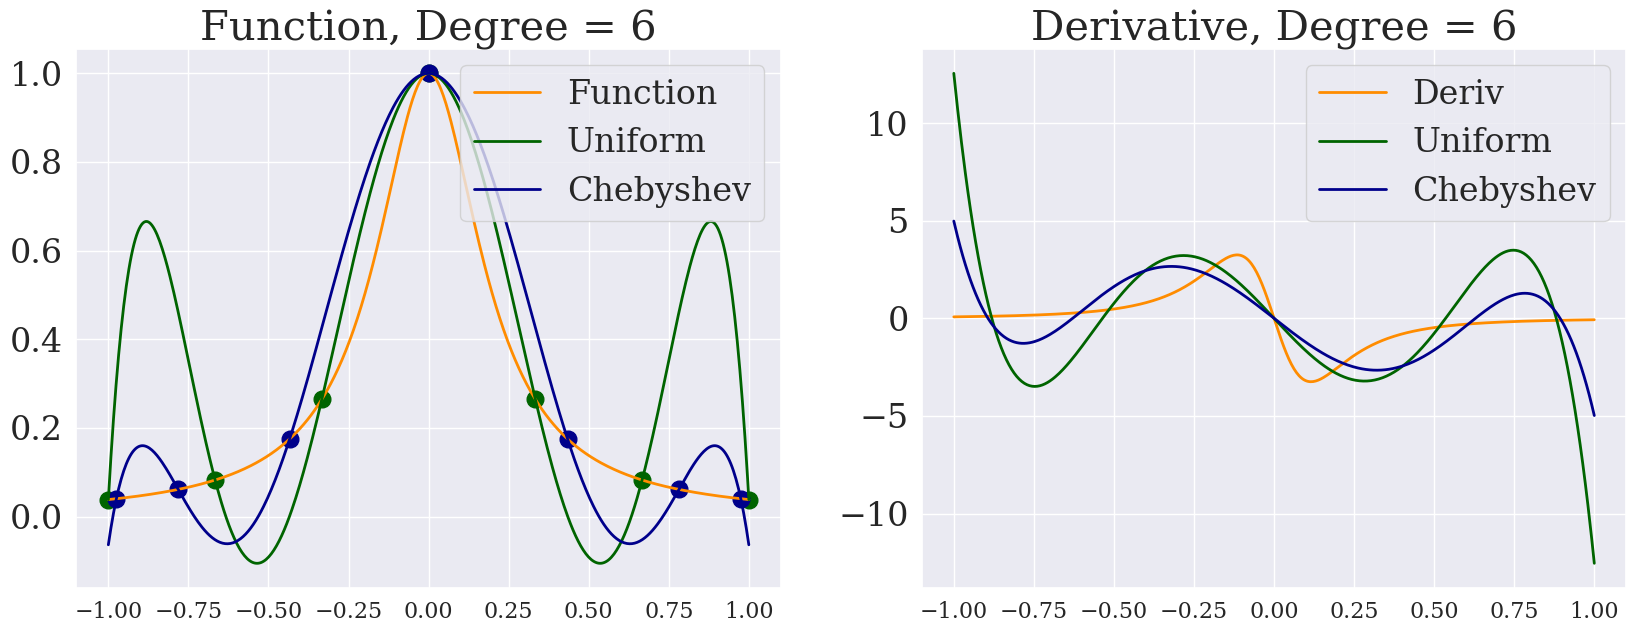

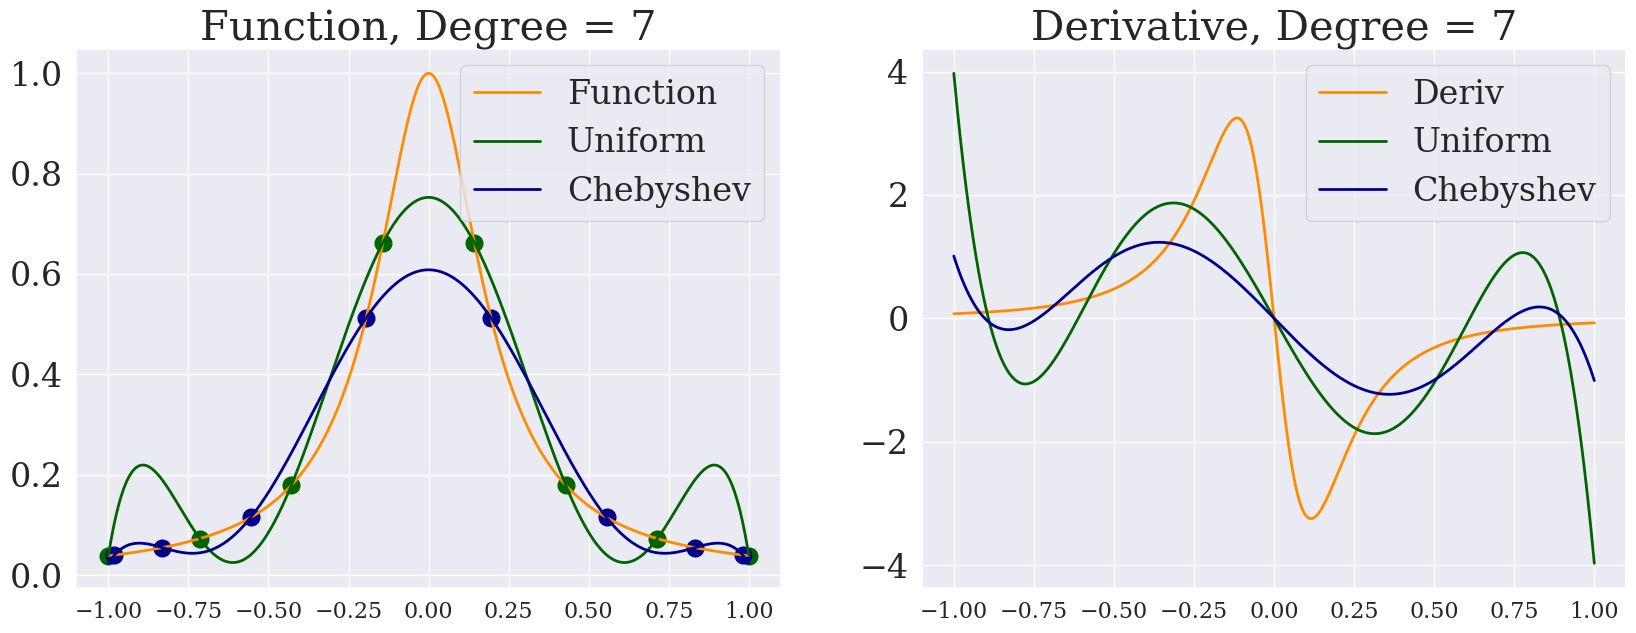

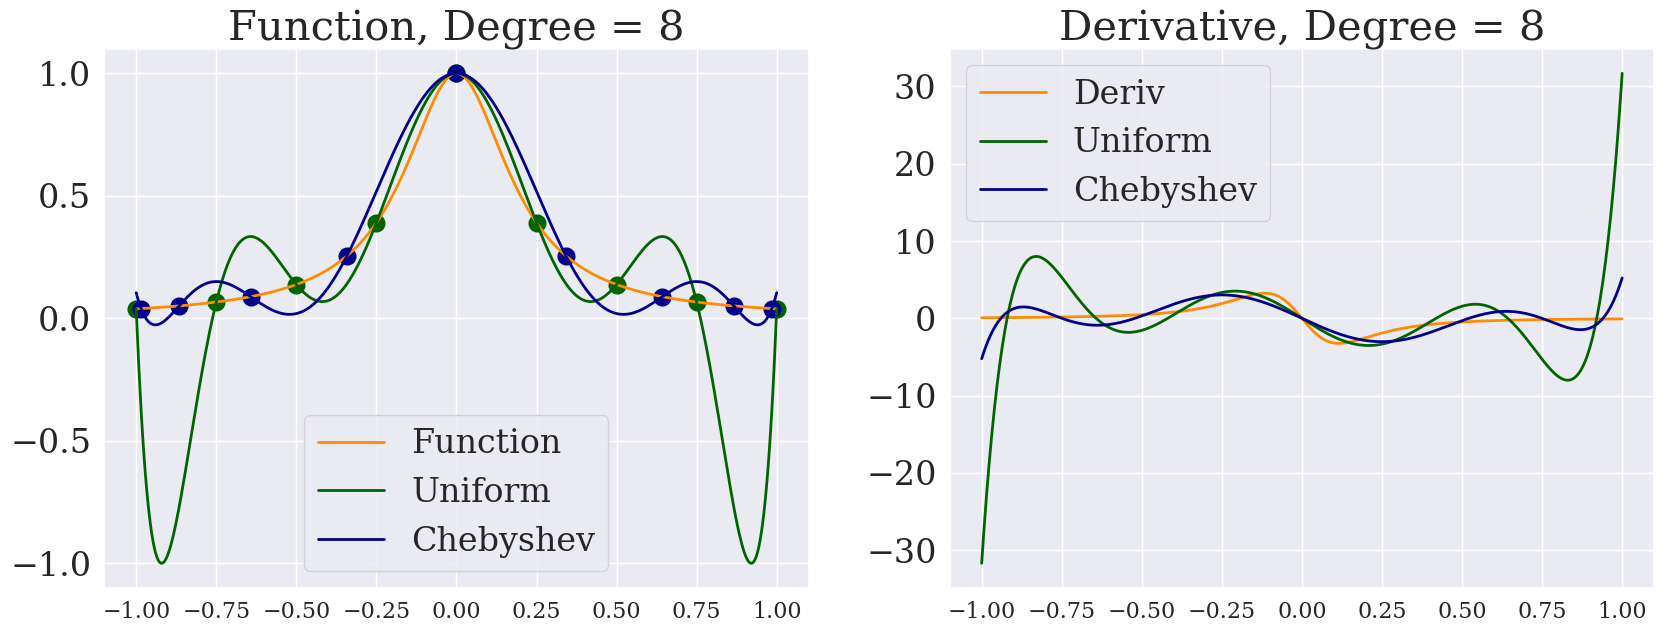

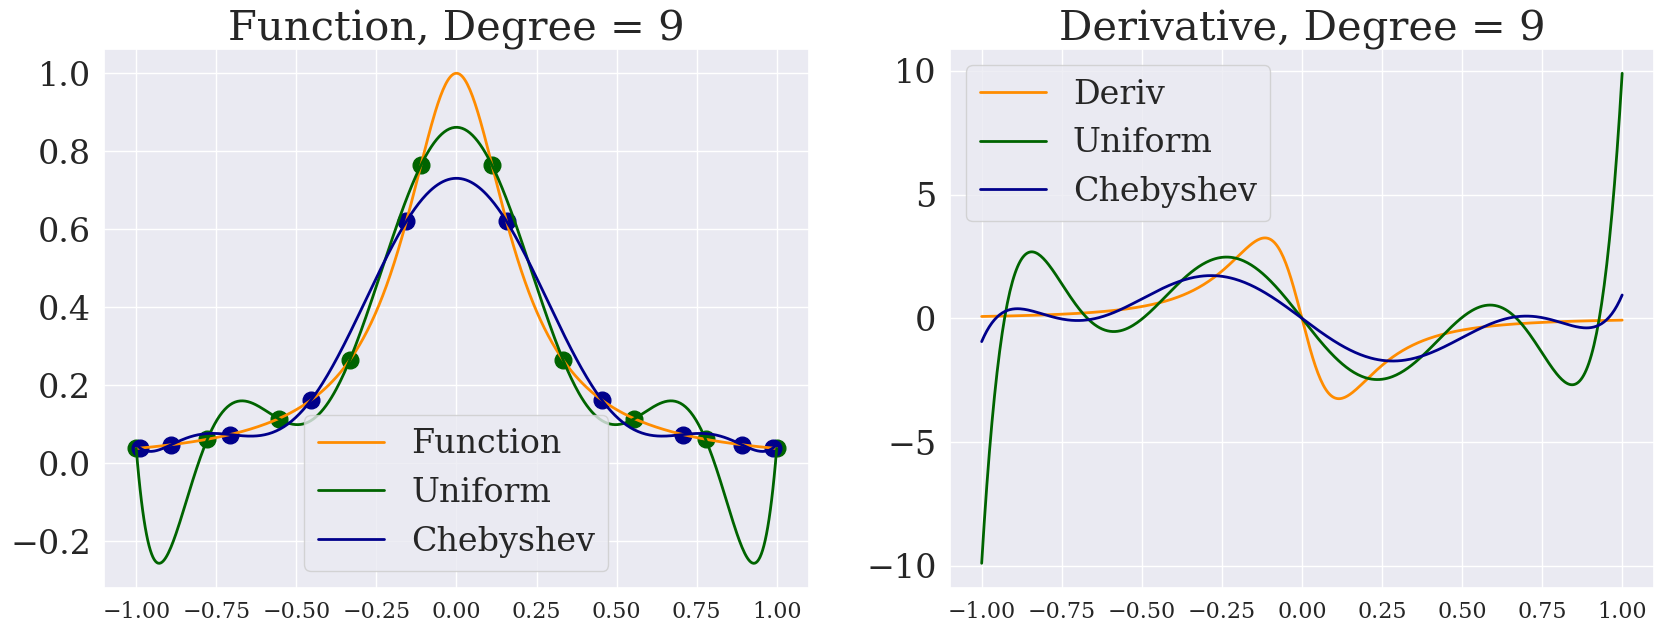

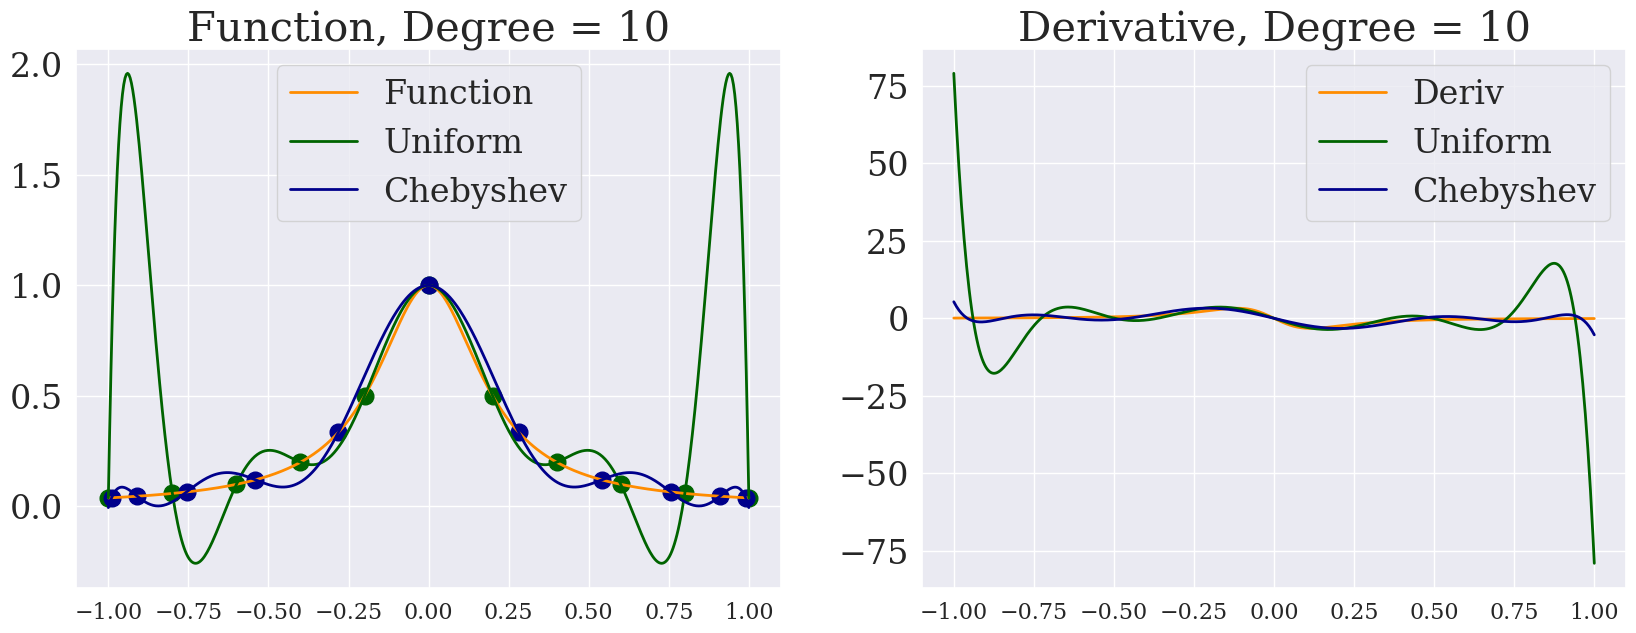

In [4]:
def func(x: np.ndarray) -> np.ndarray:
    '''
    f(x) = 1 / (1 + 25x^2)
    '''
    return (x**2 * 25 + 1) ** -1


def func_deriv(x: np.ndarray) -> np.ndarray:
    '''
    WolframAlpha: https://www.wolframalpha.com/input?i=derivative+of+1+%2F+%281+%2B+25x%5E2%29
    
    f'(x) = -50x / (1 + 25x^2)^2
    '''
    return -50*x / (x**2 * 25 + 1)**2


ticks = np.linspace(-1, 1, 500)
func_ticks = func(ticks)
func_deriv_values = func_deriv(ticks)

for degree in np.arange(1, 11):
    k_nodes = degree + 1
    uniform_grid = np.linspace(-1, 1, k_nodes)
    chebyshev_grid = np.cos((2*np.arange(1., k_nodes+1) - 1) * np.pi / (2*k_nodes))[::-1]
    
    unif_values = func(uniform_grid)
    cheb_values = func(chebyshev_grid)

    _, uniform_ticks, uniform_deriv = newton_poly(uniform_grid, unif_values, ticks)
    _, chebyshev_ticks, chebyshev_deriv = newton_poly(chebyshev_grid, cheb_values, ticks)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    
    axes[0].plot(ticks, func_ticks, color='darkorange', label='Function')
    axes[0].plot(ticks, uniform_ticks, color='darkgreen', label='Uniform')
    axes[0].plot(ticks, chebyshev_ticks, color='darkblue', label='Chebyshev')
    axes[0].scatter(uniform_grid, unif_values, color='darkgreen')
    axes[0].scatter(chebyshev_grid, cheb_values, color='darkblue')
    axes[0].set_title(f'Function, Degree = {degree}')
    axes[0].legend()
    
    axes[1].plot(ticks, func_deriv_values, color='darkorange', label='Deriv')
    axes[1].plot(ticks, uniform_deriv, color='darkgreen', label='Uniform')
    axes[1].plot(ticks, chebyshev_deriv, color='darkblue', label='Chebyshev')
    axes[1].set_title(f'Derivative, Degree = {degree}')
    axes[1].legend()
    
    plt.show()

## Матрицы дифференцирования для чебышёвских узлов

In [11]:
def calc_chebyshev_nodes(a: float, b: float, k_nodes: int) -> np.ndarray:
    if a >= b:
        raise ValueError(f'a should be lower than b, but {a} >= {b}')
    
    if k_nodes < 2:
        raise ValueError(f'k_nodes should be >= 2, but {k_nodes} < 2')
    
    k = np.arange(1, k_nodes+1)
    return np.sort((a+b)/2 + (b-a)/2 * np.cos((2*k-1) / (2*k_nodes) * np.pi))


# def build_matrix(a: float, b: float, k_nodes: int) -> np.ndarray:
#     cheb_nodes = calc_chebyshev_nodes(a, b, k_nodes)
#     mat = np.zeros((k_nodes, k_nodes))
    
#     polynoms = [Polynomial(1)] + [Polynomial.fromroots(cheb_nodes[:i]) for i in range(1, k_nodes)]
#     polynoms_deriv = list(map(lambda poly: poly.deriv(), polynoms))
    
#     mat = np.zeros((k_nodes, k_nodes))
    
#     for i in range(k_nodes):
#         mat[:, i] = polynoms_deriv[i](cheb_nodes)
        
#     return mat


def build_matrix(a: float, b: float, num_knot: int) -> np.ndarray:
    knots = calc_chebyshev_nodes(a, b, num_knot)
    M = np.zeros((num_knot, num_knot))
    
    for k in range(1, num_knot - 1):
        M[k][k + 1] = 1 / (knots[k + 1] - knots[k - 1])
        M[k][k - 1] = -M[k][k + 1]
    
    M[0][1] = 1 / (knots[1] - knots[0])
    M[0][0] = -M[0][1]
    M[-1][-1] = 1/(knots[-1] - knots[-2])
    M[-1][-2] = -M[-1][-1]
    
    return M


def get_deriv_values(a: float, b: float, k_nodes: int, func: Callable):
    cheb_nodes = calc_chebyshev_nodes(a, b, k_nodes)
    diff_mat = build_matrix(a, b, k_nodes)
    func_values = func(cheb_nodes)
    
    return diff_mat @ func_values


def holistic_pipeline(a: float, b: float, func: Callable, func_deriv: Callable) -> None:
    inf_norm_err = []
    k_nodes_range = range(10, 1001)
    
    for k_nodes in k_nodes_range:
        cheb_nodes = calc_chebyshev_nodes(a, b, k_nodes)
        deriv_values = get_deriv_values(a, b, k_nodes, func)
        true_deriv = func_deriv(cheb_nodes)
    
        inf_norm_err.append(
            np.linalg.norm(deriv_values-true_deriv, ord=np.inf)
        )
    
    plt.plot(k_nodes_range, inf_norm_err)
    plt.yscale('log')
    plt.title('Логарифм $\inf$-нормы ошибки вычисления производной')
    plt.show()

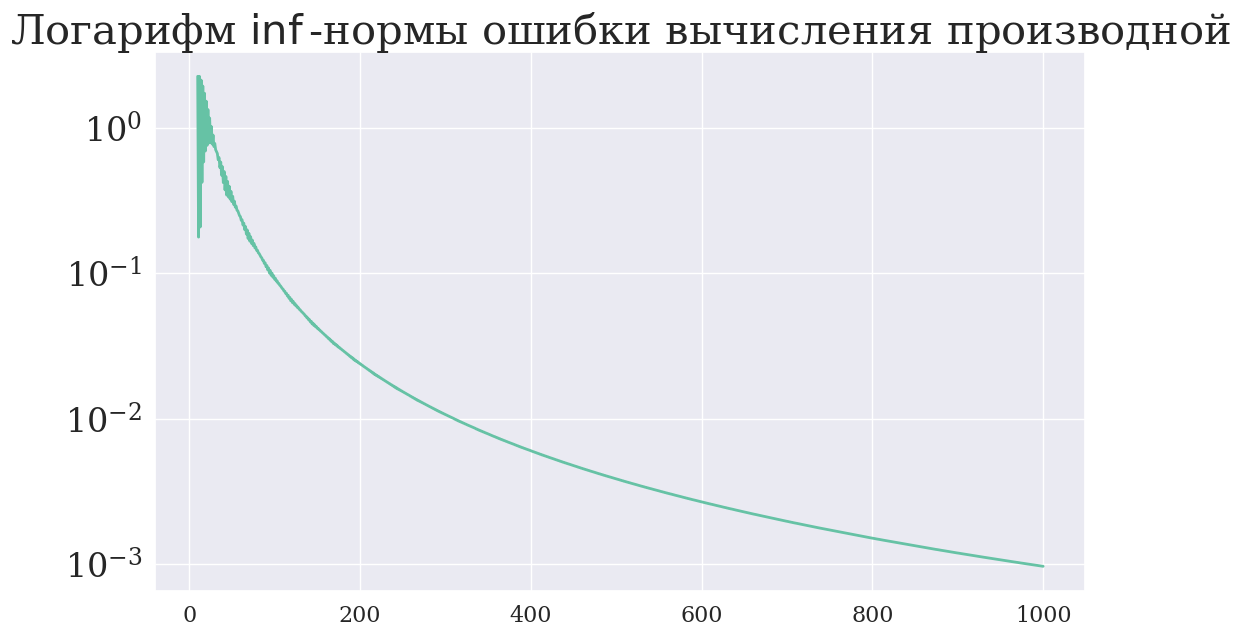

In [14]:
holistic_pipeline(-1, 1, func, func_deriv)